In [1]:
# %load defaults.ipy
# %load defaults.ipy
import sys
import os
for p in sys.path:
    if 'netcdf' in p.lower():
        sys.path.remove(p)
    if 'matplotlib' in p.lower():
        sys.path.remove(p)
from numpy import *
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 200
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import PIL



def writeMetadata(filename, data):
    im = PIL.Image.open(filename)
    
    meta = PIL.PngImagePlugin.PngInfo()

    for key in data.keys():
        meta.add_text(key, data[key])
    im.save(filename, "png", pnginfo=meta)
    
def showAndSave(name):
    fig = plt.gcf()
    ax = plt.gca()
    ax.text(0.95, 0.01, 'By Kjetil Olsen Lye\nkjetil.o.lye@gmail.com',
         fontsize=3, color='gray',
         ha='right', va='bottom', alpha=0.5, transform=ax.transAxes)

    matplotlib2tikz.save(name + '.tikz',
           figureheight = '\\figureheight',
           figurewidth = '\\figurewidth')
    
    savenamepng = name + '.png'
    plt.savefig(savenamepng)
    
    writeMetadata(savenamepng, {'Copyright' : 'Copyright, Kjetil Olsen Lye kjetil.o.lye@gmail.com'
                               })
    plt.show()
    
def legendLeft():
    ax = plt.gca()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [2]:
import sys
sys.path.append("/cluster/home/klye/alsvinn/build/python/")
sys.path.append("/home/kjetil/projects/alsvinn/build/python/")
import alsvinn

In [3]:
import re
def computeConvergence(basename, showSingle=False):
    # This run always fails, so we skip it
    if 'nieder' in basename or 'latin_center' in basename:
        return
    if 'kelvinhelmholtz' in basename:
        name = re.search(r'kelvinhelmholtz_([^/]+)\/', basename).group(1)
    else:
        name = re.search(r'brownian_(.+)\/', basename).group(1)
    print(basename)
    name = name.replace("_", " ").title()
    
    N = 256
    display(HTML("<h1>%s</h1>" % name))
    
    Ms = 2**array(range(6,11))
    
    for t in [0,1]:
        plt.figure(t)
        errors = []
        
        for M in Ms:
            filename = basename.format(M=M)
            try:
                r = alsvinn.Alsvinn(xml_file=filename, data_path=os.path.dirname(os.path.dirname(filename)))
            except Exception as e:
                print("%s failed, see error message below: " % name)
                print (e)
                return
            mean = r.get_data('rho', timestep=t, statistics='mean')
            
            
            if M > Ms[0]:
                errors.append(sqrt(sum(abs(mean-meanPrev)**2)/mean.shape[0]))
            meanPrev = mean
            if showSingle:
                x,y = mgrid[0:1:N*1j, 0:1:N*1j]
                plt.pcolormesh(x,y, mean)
                plt.ylabel('$y$')
                plt.xlabel('$x$')
                plt.title('%s, $M=%d$' % (name, M))
                plt.colorbar()
                plt.show()
        p = plt.loglog(Ms[:-1], errors, '-o',label=name)
        poly = polyfit(log(Ms[1:]), log(errors), 1)
        
        plt.loglog(Ms[1:], exp(poly[1])*Ms[1:]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
        plt.xlabel("M")
        plt.ylabel("Error")
        
        if not showSingle:
            plt.title("Cauchy convergence at $T=%d$ (normalized time)" % t)
        legendLeft()
        if showSingle:
            
            plt.title("Cauchy Convergence for %s at $T=%d$ (normalized time)" % (name,t))
            plt.show()
    
    for t in [0,1]:
        filename = basename.format(M=Ms[-1])
        try:
            r = alsvinn.Alsvinn(xml_file=filename, data_path=os.path.dirname(os.path.dirname(filename)))
        except Exception as e:
            print("%s failed, see error message below: " % name)
            print (e)
            return
        errors = []
        plt.figure(2+t)
       
        
        referenceSolution = r.get_data('rho', timestep=t, statistics='mean')
        
        for M in Ms[:-1]:
            filename = basename.format(M=M)
            try:
                r = alsvinn.Alsvinn(xml_file=filename, data_path=os.path.dirname(os.path.dirname(filename)))
            except Exception as e:
                print("%s failed, see error message below: " % name)
                print (e)
                return
            mean = r.get_data('rho', timestep=t, statistics='mean')
               
            
            
            errors.append(sqrt(sum(abs(mean-referenceSolution)**2)/mean.shape[0]))
           
        p = plt.loglog(Ms[:-1], errors, '-o',label=name)
        poly = polyfit(log(Ms[1:]), log(errors), 1)
        
        plt.loglog(Ms[1:], exp(poly[1])*Ms[1:]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
        plt.xlabel("M")
        plt.ylabel("Error")
        if not showSingle:
            plt.title("Convergence against reference solution\n$T=%d$ (normalized time)" % t)
        
        legendLeft()
        if showSingle:
            plt.title("Convergence for %s at $T=%d$ (normalized time)\nagainst reference solution" % (name,t))
            plt.show()
    

# Kelvin-Helmholtz

here we test the Kelvin-Helmholtz initial data. This initial data uses 40 random variables.

../configs_euler/kelvinhelmholtz_faure/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


../configs_euler/kelvinhelmholtz_halton/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


../configs_euler/kelvinhelmholtz_hammersley/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


../configs_euler/kelvinhelmholtz_latin_random/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


../configs_euler/kelvinhelmholtz_sobol/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


../configs_euler/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


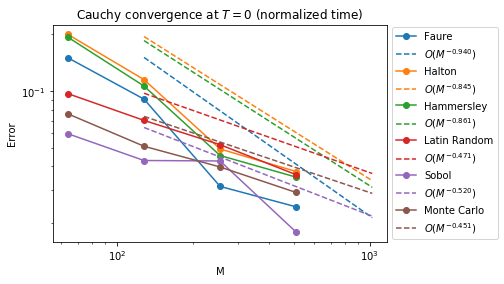

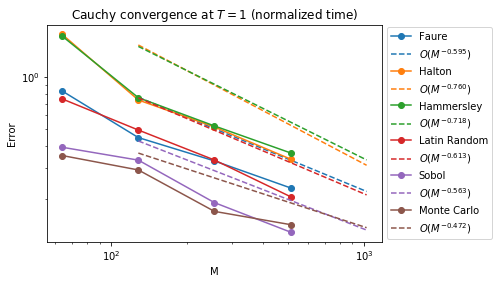

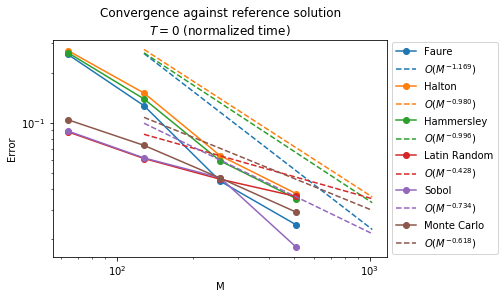

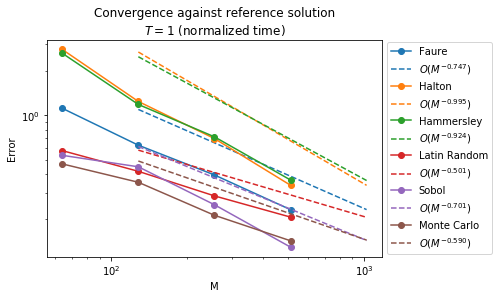

In [4]:
import glob

for basename in glob.glob("../configs_euler/kelvinhelmholtz_*"):
    computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml")

../configs_euler/kelvinhelmholtz_faure/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


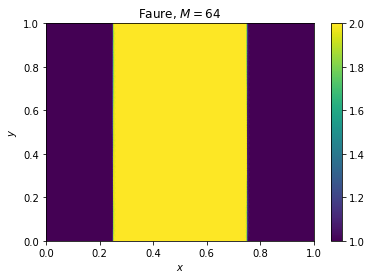

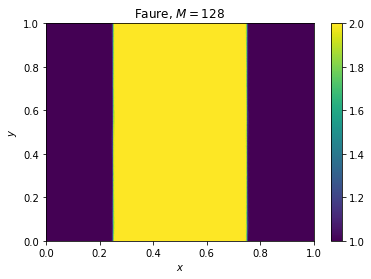

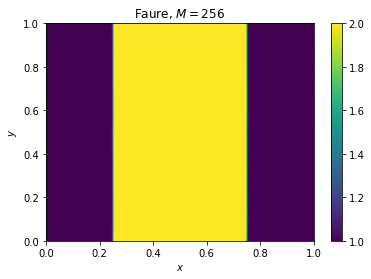

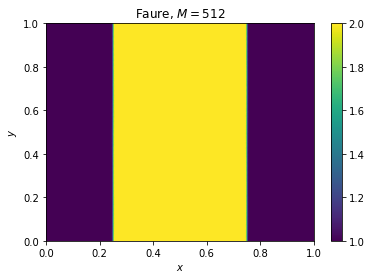

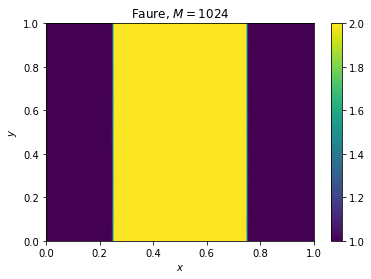

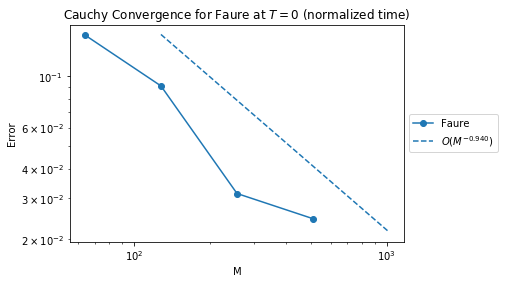

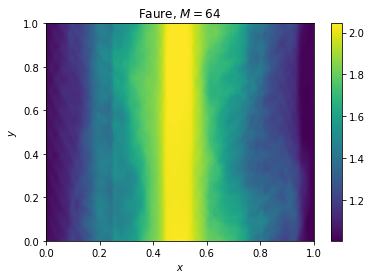

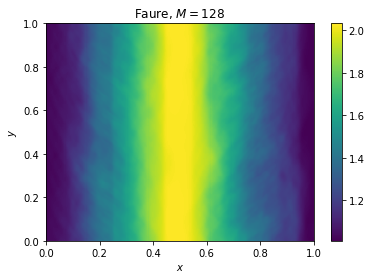

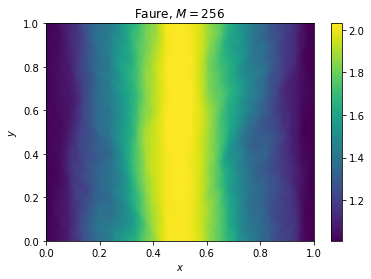

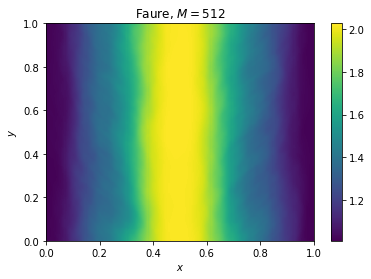

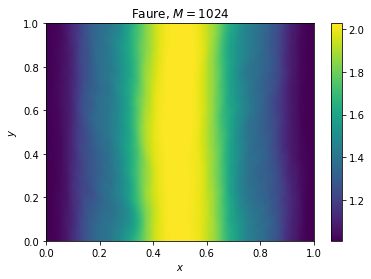

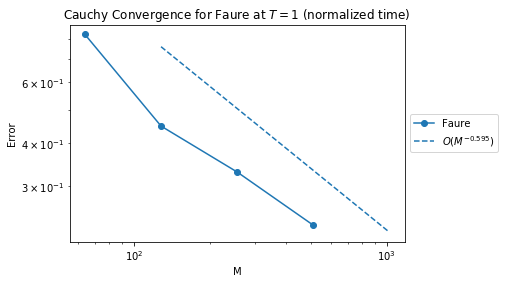

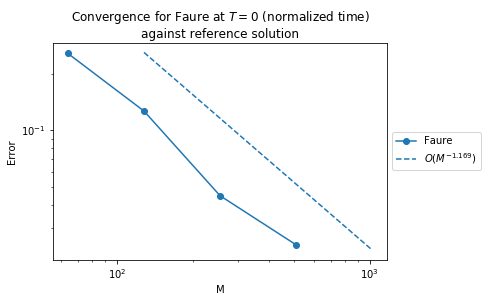

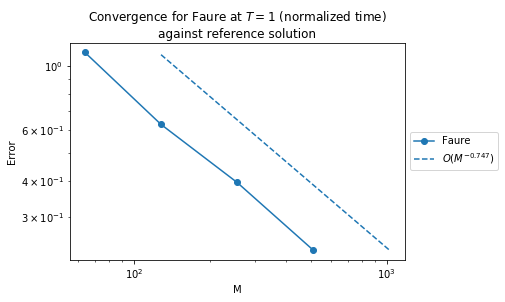

../configs_euler/kelvinhelmholtz_halton/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


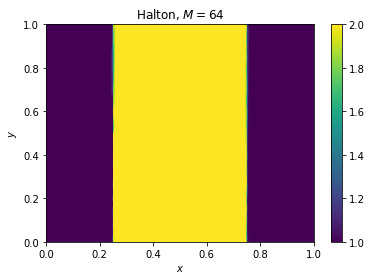

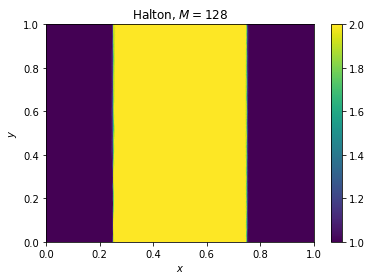

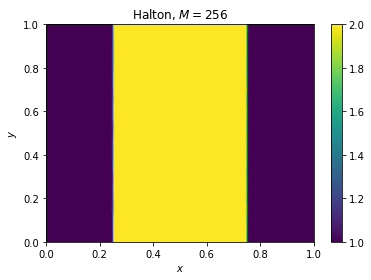

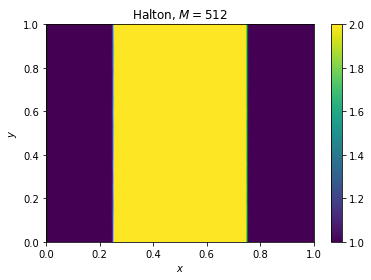

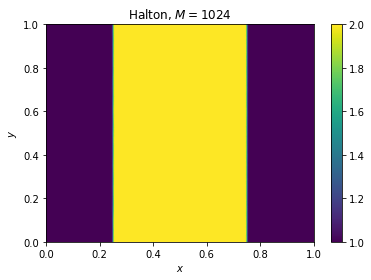

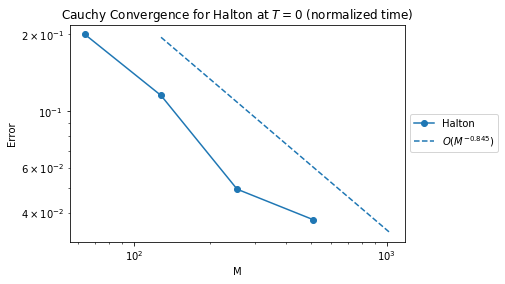

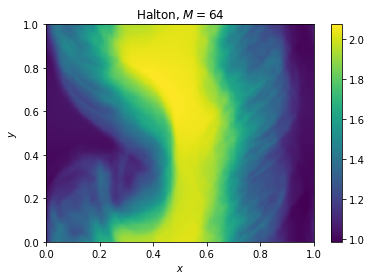

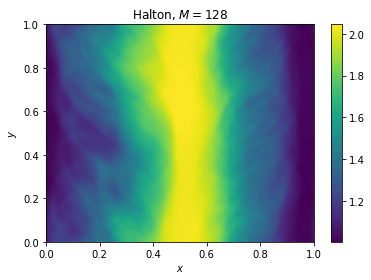

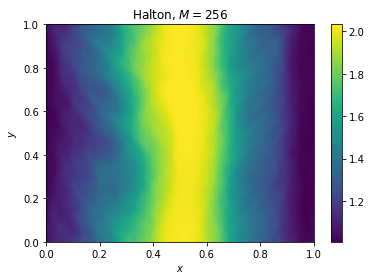

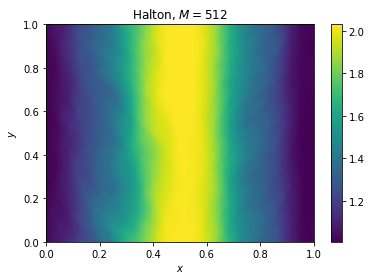

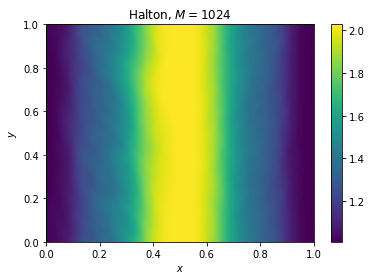

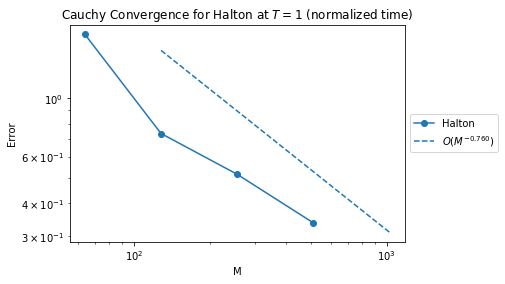

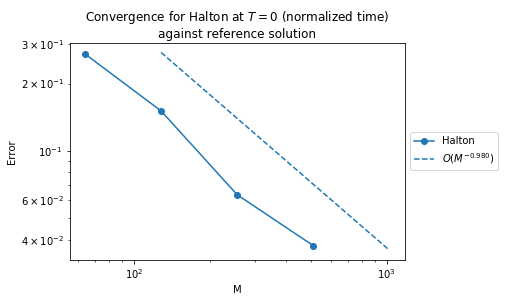

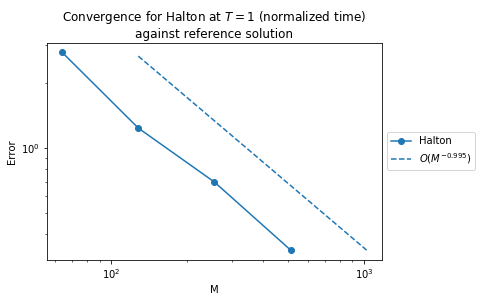

../configs_euler/kelvinhelmholtz_hammersley/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


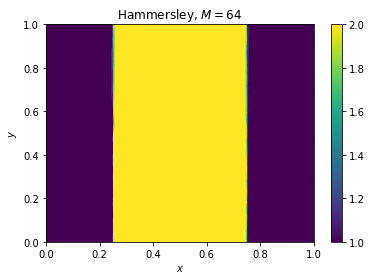

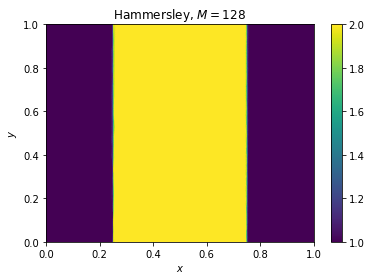

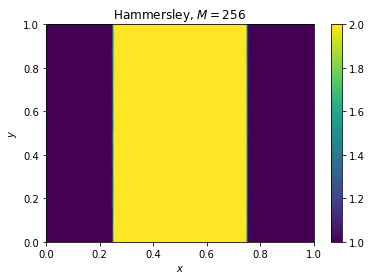

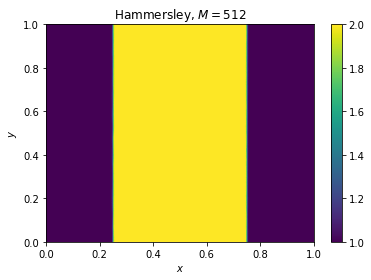

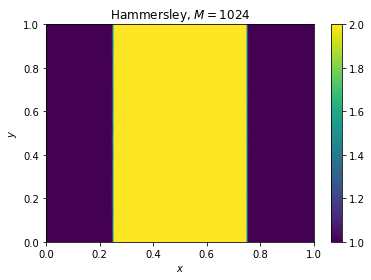

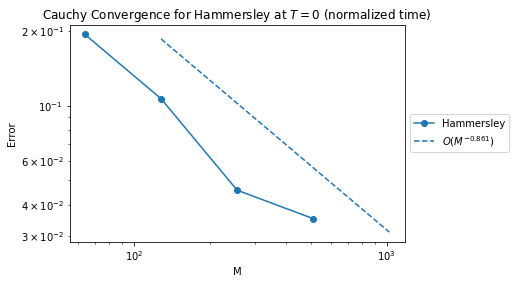

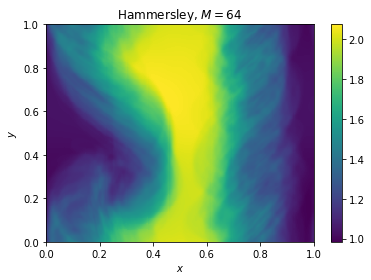

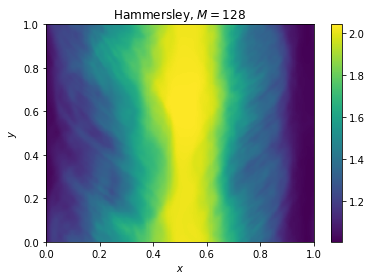

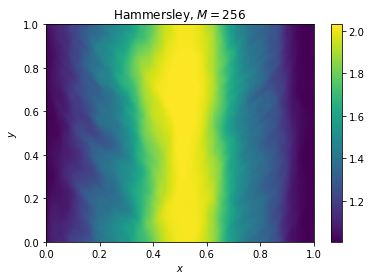

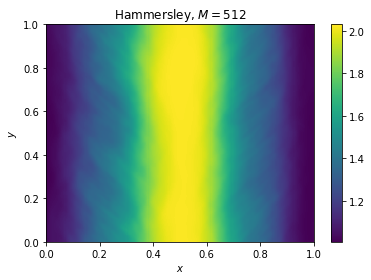

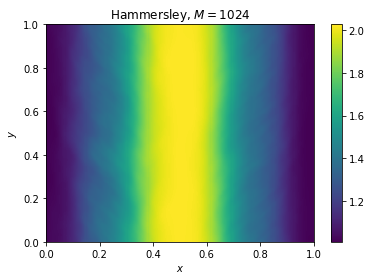

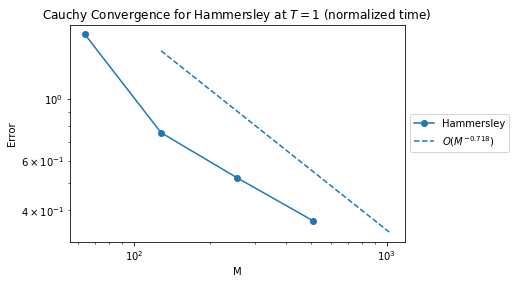

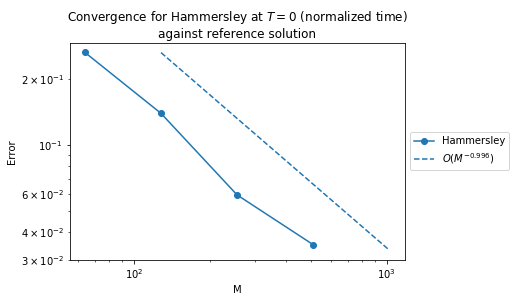

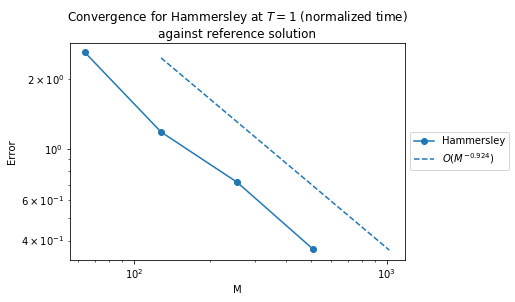

../configs_euler/kelvinhelmholtz_latin_random/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


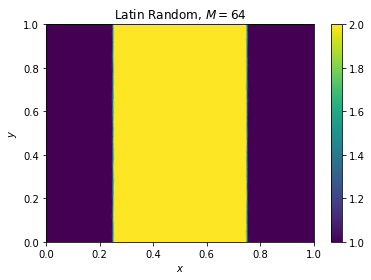

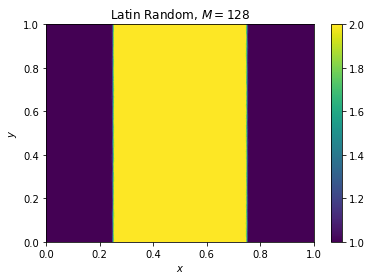

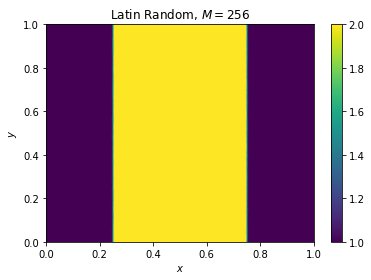

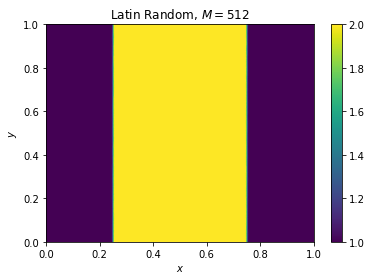

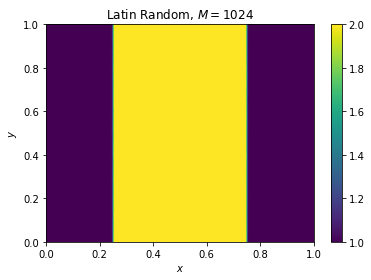

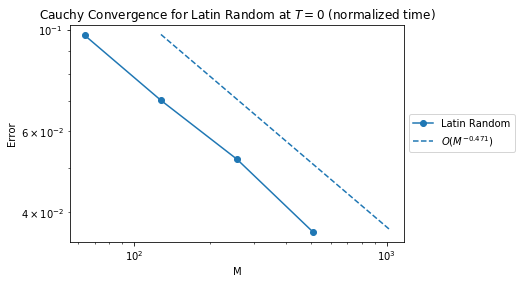

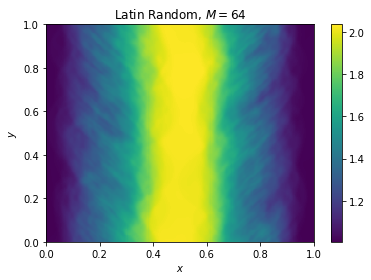

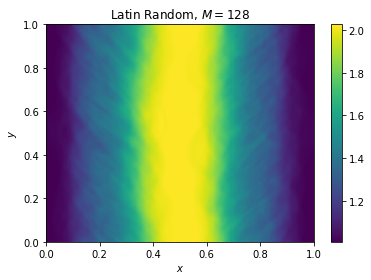

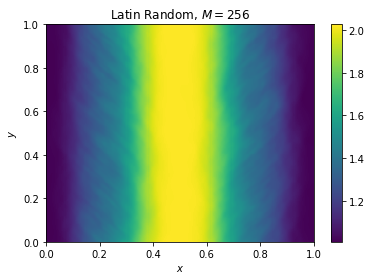

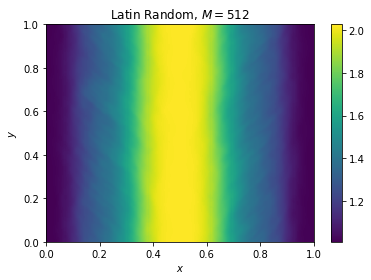

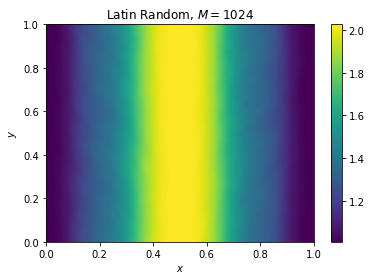

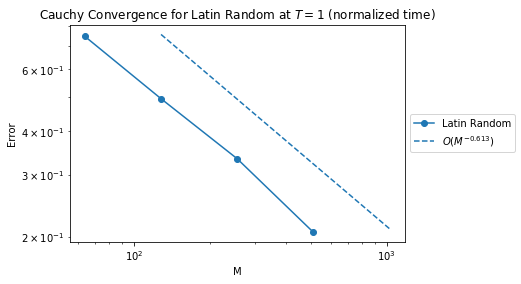

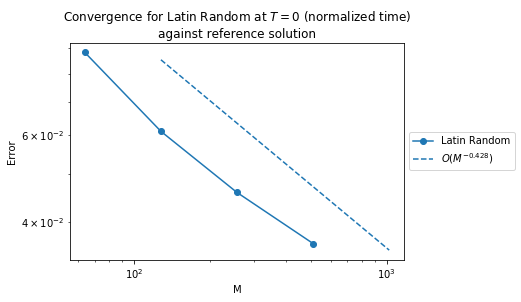

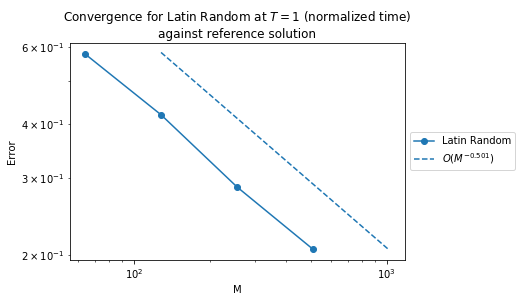

../configs_euler/kelvinhelmholtz_sobol/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


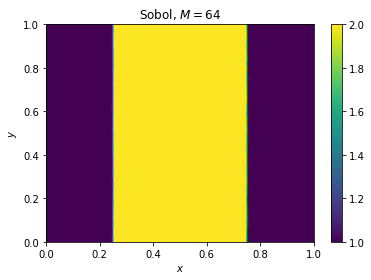

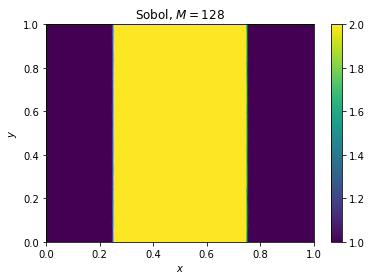

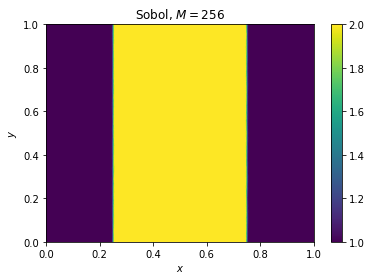

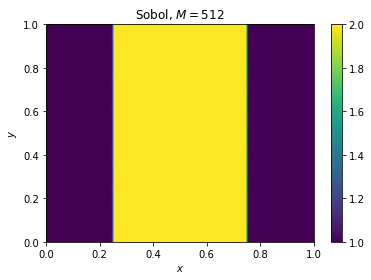

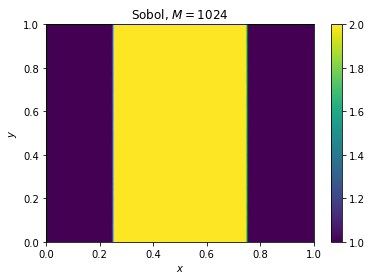

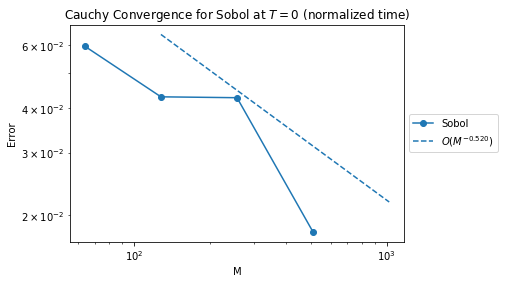

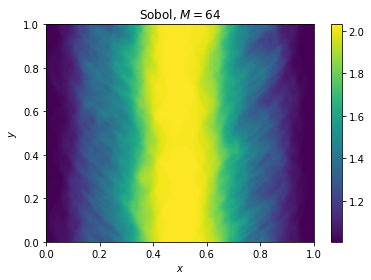

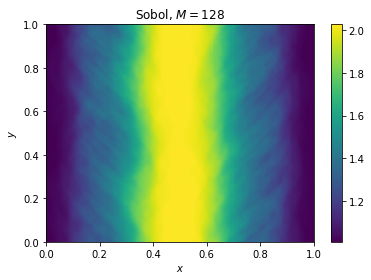

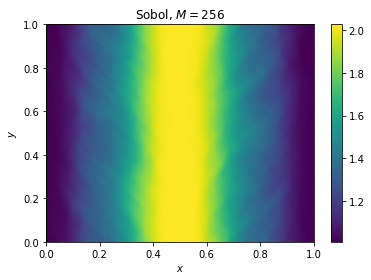

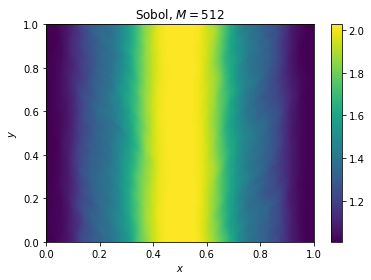

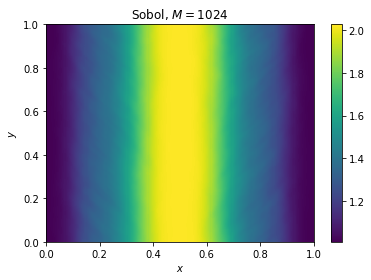

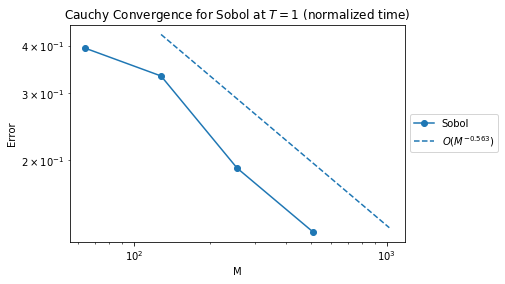

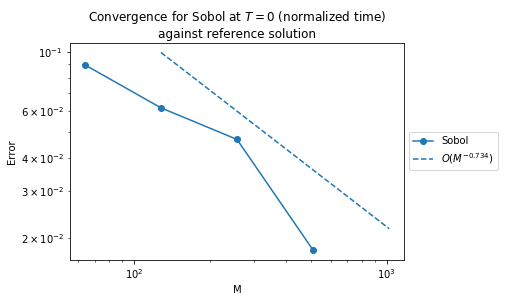

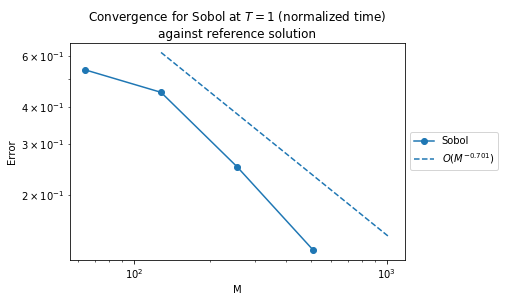

../configs_euler/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


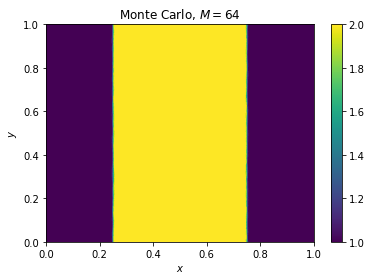

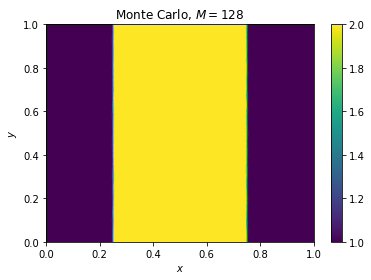

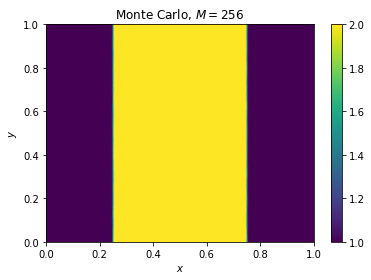

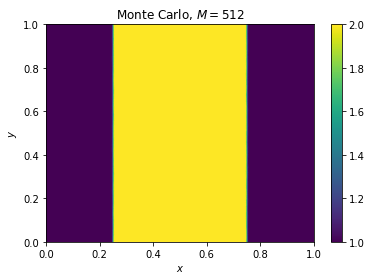

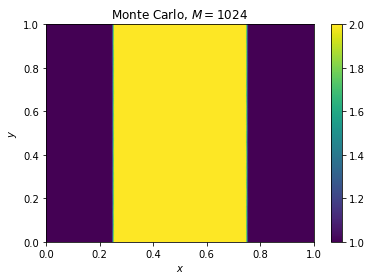

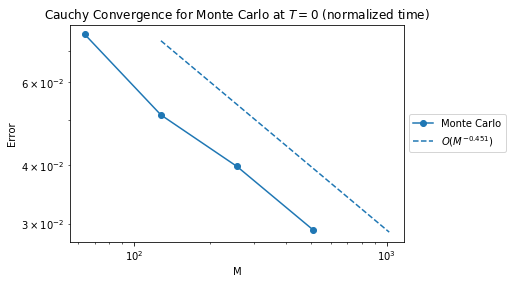

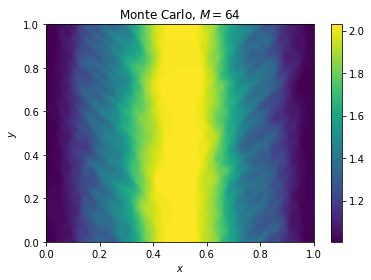

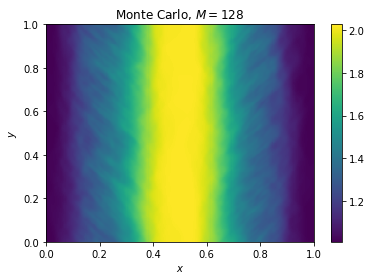

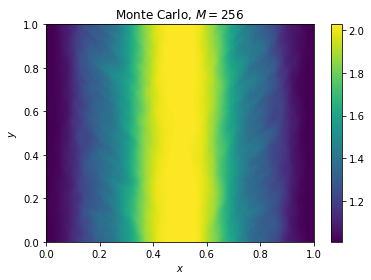

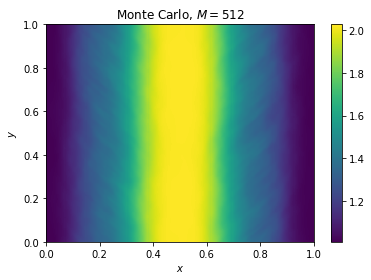

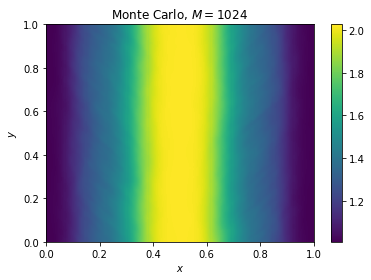

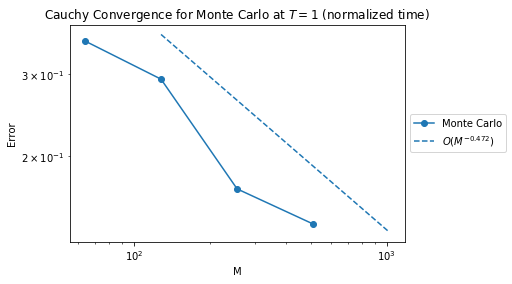

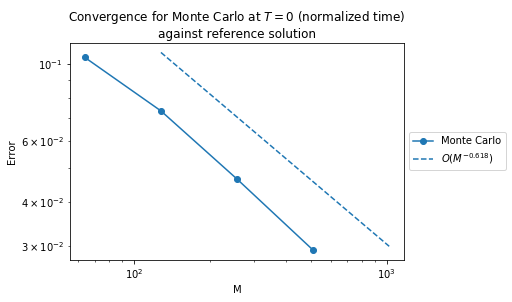

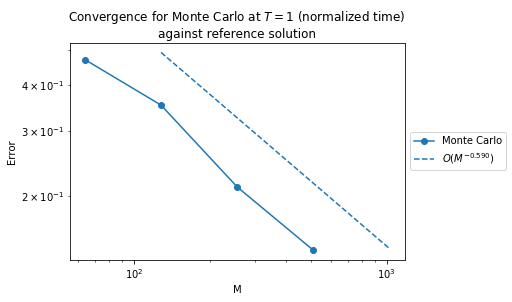

In [5]:
import glob

for basename in glob.glob("../configs_euler/kelvinhelmholtz_*"):
    computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", True)

# Brownian initial data

Here we let the initial data be given as (truncated) Brownian motion, and we set
$$u^x_0(\omega, x,y) = B^1_{x,y}(\omega)\qquad u^y_0(\omega, x,y)=B^2_{x,y}(\omega)$$
for two independent two dimensional Brownian motions $B^1$ and $B^2$. We set the initial pressure and density to be constant.

In the approximation, we use $256^2$ dimensions. Not all QMC rules are able to handle this dimension, they are skipped.

In [6]:
import glob

#for basename in glob.glob("../configs/brownian_*"):
#    computeConvergence(basename + "/brownian.xml")

In [7]:
import glob

#for basename in glob.glob("../configs/brownian_*"):
#    computeConvergence(basename + "/brownian.xml", True)